In [1]:
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification

Dataset URL: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification
License(s): CC0-1.0
traffic-sign-dataset-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip traffic-sign-dataset-classification.zip -d traffic-sign-dataset-classification

Archive:  traffic-sign-dataset-classification.zip
replace traffic-sign-dataset-classification/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2
import pathlib
import PIL
import random

In [2]:
labels_df = pd.read_csv('/content/traffic-sign-dataset-classification/labels.csv')
labels_df.head()

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [3]:
len(labels_df)

58

In [3]:
train_data_dir = pathlib.Path('/content/traffic-sign-dataset-classification/traffic_Data/DATA')

In [4]:
train_data_count = len(list(train_data_dir.glob('*/*.png')))

In [5]:
train_data_count

4170

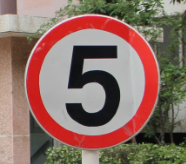

In [6]:
category_0 = list(train_data_dir.glob('0/*'))
PIL.Image.open(category_0[0])

In [7]:
dir = os.listdir(train_data_dir)
print(dir)

['12', '11', '46', '26', '33', '36', '19', '31', '32', '40', '52', '43', '23', '1', '28', '16', '4', '34', '24', '30', '53', '0', '25', '3', '18', '48', '6', '27', '45', '14', '10', '21', '15', '29', '7', '47', '55', '44', '37', '13', '42', '54', '49', '22', '9', '5', '57', '17', '56', '8', '20', '50', '2', '41', '35', '38', '39', '51']


In [8]:
training_examples_perclass = []
class_names = []
train_images = []
for folder in os.listdir(train_data_dir):
  folder_path = train_data_dir / folder
  images = list(folder_path.glob('*'))
  training_examples_perclass.append(len(images))
  class_names.append(labels_df['Name'][int(folder)])

In [9]:
print(training_examples_perclass)
print(class_names)
sum(training_examples_perclass)

[96, 138, 18, 126, 4, 40, 4, 42, 14, 32, 36, 82, 14, 40, 446, 142, 98, 26, 100, 150, 2, 118, 2, 260, 8, 10, 78, 28, 24, 128, 70, 12, 22, 44, 152, 12, 162, 30, 58, 36, 32, 324, 42, 18, 2, 194, 6, 130, 110, 8, 18, 56, 80, 18, 156, 30, 34, 8]
['Dont Go Left or Right', 'Dont Go Left', 'ZigZag Curve', 'keep Right', 'Traffic signals', 'Bicycles crossing', 'Speed limit (50km/h)', 'Uturn', 'Road Divider', 'Unknown1', 'Unknown6', 'Go right or straight', 'Go Left or right', 'Speed limit (15km/h)', 'watch out for cars', 'No Car', 'Speed limit (50km/h)', 'Danger Ahead', 'Go Right', 'Bicycles crossing', 'Give Way', 'Speed limit (5km/h)', 'keep Left', 'Speed limit (40km/h)', 'Speed limit (40km/h)', 'Under Construction', 'Speed limit (70km/h)', 'Roundabout mandatory', 'Unknown4', 'Dont overtake from Left', 'Dont Go straight', 'Go straight', 'No Uturn', 'Horn', 'speed limit (80km/h)', 'Train Crossing', 'No entry', 'Go left or straight', 'Children crossing', 'Dont Go Right', 'Unknown3', 'No stopping', 

4170

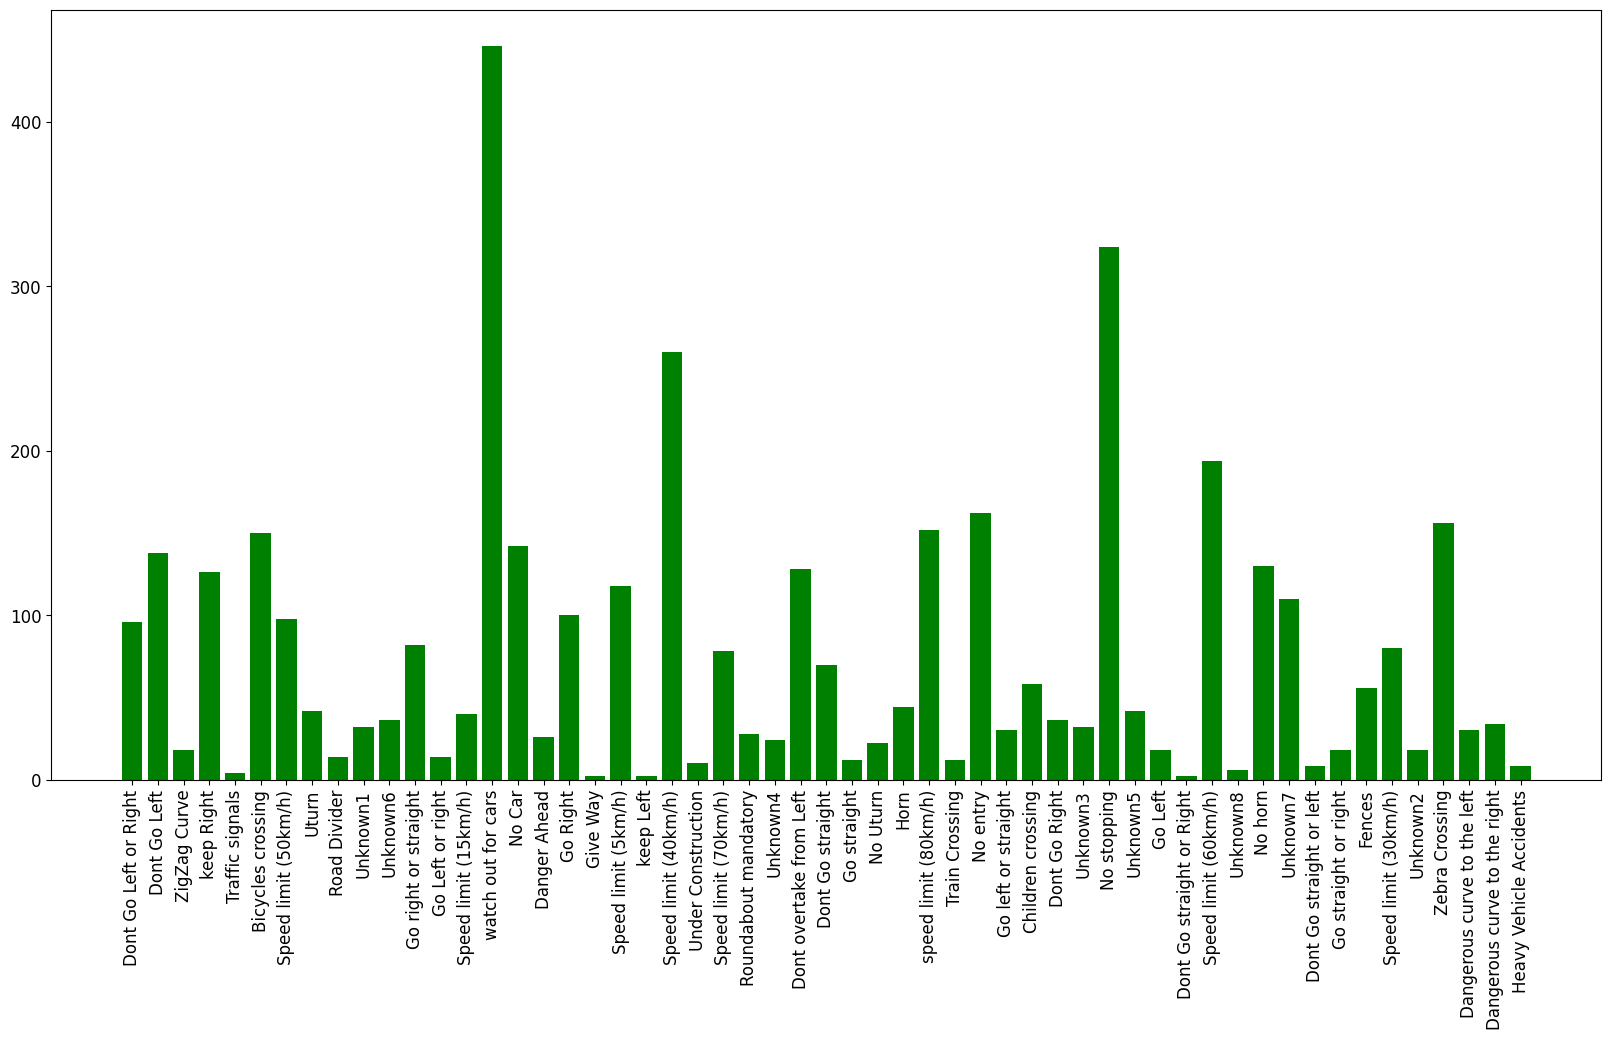

In [10]:
plt.figure(figsize=(20,10))
plt.bar(class_names, training_examples_perclass, color='green')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [11]:
# displaying random images from training set
def random_image_displayer(directory,num_images):
  images = []
  classes = [dir for dir in directory.iterdir() if dir.is_dir()]
  if len(classes)!= 0:
    for folder in classes:
      images.extend(list(folder.glob('*')))
  else:
    images.extend(list(directory.glob('*')))
  random_images = random.sample(images, num_images)
  columns = (num_images+1)//2
  plt.figure(figsize=(20,10))
  for i, img_path in enumerate(random_images):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, columns, i + 1)
    plt.imshow(img)
    if len(classes) != 0:
       plt.title(f'Class:{img_path.parent.name}', fontsize=10)
       plt.text(
            0.5, -0.1, f"Label: {labels_df['Name'][int(img_path.parent.name)]}",
            size=12, ha='center', transform=plt.gca().transAxes
        )
    plt.axis('off')
  plt.show()



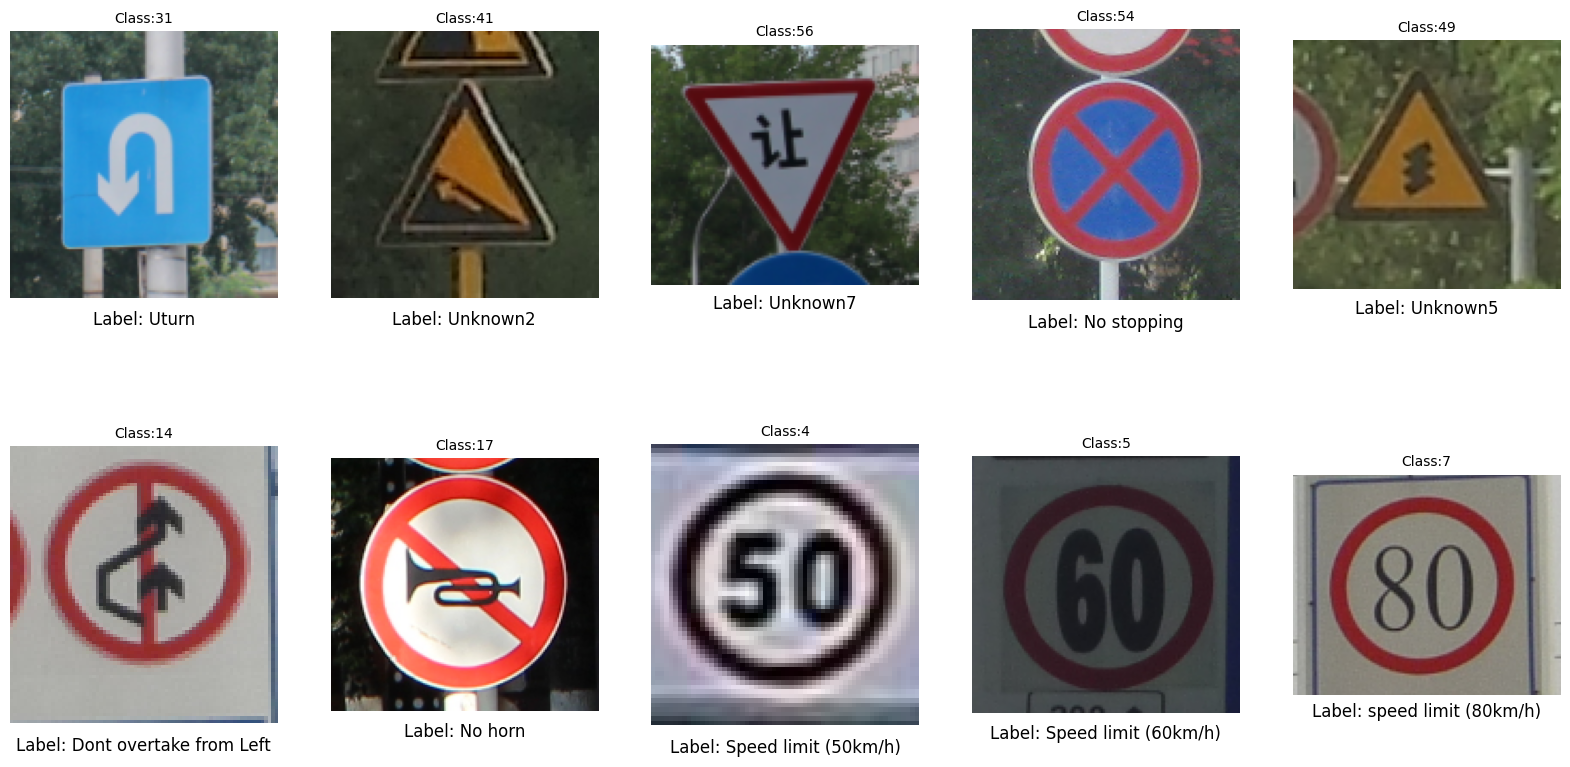

In [12]:
random_image_displayer(train_data_dir, 10)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_data = train_datagen.flow_from_directory(
    directory=str(train_data_dir),
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    directory=str(train_data_dir),
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Found 3359 images belonging to 58 classes.
Found 811 images belonging to 58 classes.


In [16]:
model = models.Sequential([
    #cnn
    layers.Conv2D(16, (3,3), padding='same', activation ='relu', input_shape=(180,180,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    #dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(labels_df), activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)        0

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(train_data, epochs=20, validation_data=validation_data)

Epoch 1/20
105/105 [==============================] - 155s 1s/step - loss: 2.8300 - accuracy: 0.2870 - val_loss: 2.2234 - val_accuracy: 0.3329
Epoch 2/20
105/105 [==============================] - 145s 1s/step - loss: 2.0366 - accuracy: 0.4099 - val_loss: 1.9192 - val_accuracy: 0.4340
Epoch 3/20
105/105 [==============================] - 150s 1s/step - loss: 1.6383 - accuracy: 0.5115 - val_loss: 1.6785 - val_accuracy: 0.4797
Epoch 4/20
105/105 [==============================] - 144s 1s/step - loss: 1.3774 - accuracy: 0.5838 - val_loss: 1.4232 - val_accuracy: 0.5783
Epoch 5/20
105/105 [==============================] - 159s 2s/step - loss: 1.1898 - accuracy: 0.6368 - val_loss: 1.2455 - val_accuracy: 0.6153
Epoch 6/20
105/105 [==============================] - 146s 1s/step - loss: 1.0204 - accuracy: 0.6871 - val_loss: 1.1153 - val_accuracy: 0.6572
Epoch 7/20
105/105 [==============================] - 150s 1s/step - loss: 0.8995 - accuracy: 0.7181 - val_loss: 1.0785 - val_accuracy: 0.6658

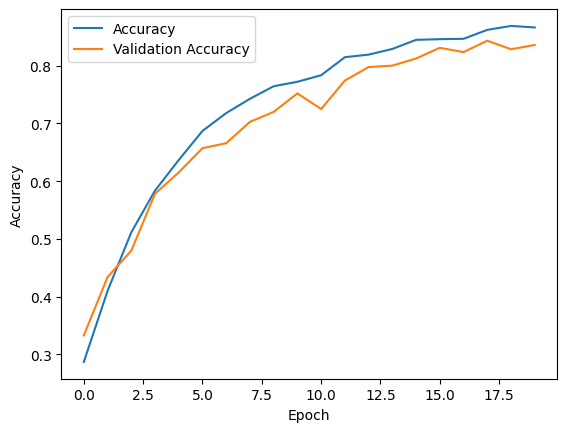

In [23]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Accuracy","Validation Accuracy"])